In [1]:
import sys

if (
    "/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem"
    not in sys.path
):
    sys.path.append(
        "/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem"
    )
print(sys.path)

['/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem/experiments', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python310.zip', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/lib-dynload', '', '/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages', '/Users/carterblair/waterloo/research/BanditLiquidDem/banditLiquidDem']


In [2]:
import os
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.learning import Net
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from avalanche.training.supervised import Naive
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
import numpy as np
import matplotlib as mpl
import seaborn as sns
from itertools import product
import pandas as pd
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from avalanche.training import plugins as plg
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

from avalanche.training import EWC

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set max rows to display in pandas
pd.set_option("display.max_rows", 500)

### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

### Set up global experiment settings

In [4]:
batch_size = 128
window_size = 50
num_trials = 10
n_voters = 8

ensemble_width = 64
single_width = 512

exp_name_suffix = "CAI-experiments-feb16"  # adjust as useful to avoid overwriting data!
# exp_name_suffix = "all_avalanche_scratch"

#### Create Delegation Mechanisms

### Create Delegation Mechanisms and Ensembles

For simplicity, only explore full ensemble and variants of ProbaSlopeDelegationMechanism since they can be created programmatically.

In [5]:
def get_ensembles_dict(lo_num_gurus=[1, 2, 3, 4]):
    NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)
    NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

    probability_functions = [
        "random_better",
        "probabilistic_better",
        "probabilistic_weighted",
        "max_diversity",
    ]
    score_functions = [
        "accuracy_score",
        "balanced_accuracy_score",
        "f1_score",
        # "precision_score",
        # "recall_score",
        # "top_k_accuracy_score",
        # "roc_auc_score",
        # "log_loss_score",
        # "max_diversity",
    ]
    # probability_functions = ["max_diversity"]
    # score_functions = ["accuracy_score"]

    del_mechs = {"full-ensemble": NOOP_del_mech}
    for prob_func, score_func, num_gurus in product(
        probability_functions, score_functions, lo_num_gurus
    ):
        dm = ProbaSlopeDelegationMechanism(
            batch_size=batch_size,
            window_size=window_size,
            max_active=num_gurus,
            probability_function=prob_func,
            score_method=score_func,
        )
        del_mechs[f"{prob_func}-{score_func}-num_gurus-{num_gurus}"] = dm

    for num_gurus_train in lo_num_gurus:
        for num_gurus_test in lo_num_gurus:
            dm = StudentExpertDelegationMechanism(
                batch_size=batch_size,
                window_size=window_size,
                max_active_train=num_gurus_train,
                max_active_test=num_gurus_test,
            )
            del_mechs[
                f"StudentExpert-num_gurus_train-{num_gurus_train}-num_gurus_test-{num_gurus_test}"
            ] = dm

    ensembles_dict = {
        dm_name: Ensemble(
            training_epochs=1,
            n_voters=n_voters,
            delegation_mechanism=dm,
            name=dm_name,
            input_dim=28 * 28,
            output_dim=10,
            width=ensemble_width,
        )
        for dm_name, dm in del_mechs.items()
    }
    ensembles_dict["single_Net"] = Ensemble(
        training_epochs=1,
        n_voters=1,
        delegation_mechanism=NOOP_del_mech2,
        name="single_Net",
        input_dim=28 * 28,
        output_dim=10,
        width=single_width,
    )
    return ensembles_dict

#### Create Avalanche Strategies to Compare Against

In [6]:
def initialize_strategies_to_evaluate():
    plugins_to_evaluate = {
        "AGEM": plg.AGEMPlugin(
            patterns_per_experience=50, sample_size=256
        ),  # https://arxiv.org/pdf/1812.00420.pdf
        "CoPE": plg.CoPEPlugin(p_size=10),  # has default parameters in Avalanche
        "CWR": "LATER",  # mostly has default parameters (?)
        "EWC": plg.EWCPlugin(ewc_lambda=0.001),
        "GDumb": plg.GDumbPlugin(),
        "GEM": plg.GEMPlugin(
            patterns_per_experience=5120, memory_strength=0.5
        ),  # https://arxiv.org/pdf/1706.08840.pdf
        # "GSS_greedy": plg.GSS_greedyPlugin(),
        "LFL": plg.LFLPlugin(lambda_e=0.0016),  # https://arxiv.org/pdf/1607.00122.pdf
        "LwF": plg.LwFPlugin(),
        "Replay": plg.ReplayPlugin(mem_size=100),
        "SynapticIntelligence": plg.SynapticIntelligencePlugin(si_lambda=0.5),
        "MAS": plg.MASPlugin(),
        "TrainGeneratorAfterExp": plg.TrainGeneratorAfterExpPlugin(),
        "RWalk": plg.RWalkPlugin(),
        # "GenerativeReplay": plg.GenerativeReplayPlugin()
        # "BiC": plg.BiCPlugin(),
        "MIR": plg.MIRPlugin(batch_size_mem=10),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():
        model = Net(input_dim=28 * 28, output_dim=10, width=single_width)
        if name == "CWR":
            strategies_to_evaluate["CWR"] = plg.CWRStarPlugin(model)
            pte = strategies_to_evaluate["CWR"]
        if name == "LFL":
            from avalanche.models import SimpleMLP

            model = SimpleMLP(num_classes=10, hidden_layers=2, hidden_size=single_width)

        optimize = optim.Adam(model.parameters(), lr=0.001)

        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval,
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval],
        )
        # cl_strategy = EWC(
        #     model=model,
        #     optimizer=optimize,
        #     criterion=CrossEntropyLoss(),
        #     ewc_lambda=0.001,
        #     train_mb_size=batch_size,
        #     train_epochs=1,
        #     eval_mb_size=batch_size,
        # )
        strategies_to_evaluate[name] = (cl_strategy, evp)

    return strategies_to_evaluate

# Run Experiment

### Train Ensemble - single active voter

In [7]:
# Train ensembles - single guru

# data = SplitMNIST(n_experiences=5, fixed_class_order=list(range(10)))


ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    # benchmark=data,
    dataset_name="SplitMNIST",
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]

Starting trial  0


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 67.89it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0679
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9910
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 39.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 32.2794
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 73.74it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1857
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9779
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 61.83it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 10%|█         | 1/10 [17:16<2:35:30, 1036.75s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.3160
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9067
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.0389
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6671
Starting trial  1


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 62.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0673
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9880
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 35.70it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 33.3906
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1925
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9652
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 63.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 20%|██        | 2/10 [35:44<2:23:46, 1078.31s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9632
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.5290
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.2927
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3275
Starting trial  2


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 60.14it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0601
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9878
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:03, 32.07it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 28.4465
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0547
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 59.94it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2005
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9299
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 60.38it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 30%|███       | 3/10 [55:56<2:12:55, 1139.37s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.4764
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8457
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.9891
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6063
Starting trial  3


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 60.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0823
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9860
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 35.51it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 36.5154
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0312
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 61.00it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1928
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9460
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 65.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 40%|████      | 4/10 [1:16:21<1:57:18, 1173.11s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.4123
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8659
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.8297
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4573
Starting trial  4


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.61it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0712
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9884
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 37.23it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 44.3633
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0078
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 65.94it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1932
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9566
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 62.26it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 50%|█████     | 5/10 [1:37:20<1:40:20, 1204.17s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.2975
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9203
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.2026
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5361
Starting trial  5


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0672
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9908
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 38.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 85.3029
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4375
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 64.96it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2011
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9304
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 65.30it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 60%|██████    | 6/10 [1:58:24<1:21:38, 1224.69s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 1.2159
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.4851
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.1864
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4340
Starting trial  6


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 68.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0836
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9866
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 39.17it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 62.3400
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0312
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.27it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1981
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9343
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.87it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 70%|███████   | 7/10 [2:16:41<59:08, 1182.70s/it]  


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.5716
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8533
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.2701
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4905
Starting trial  7


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.97it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0685
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9881
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 38.91it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 44.6669
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0391
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 65.50it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1976
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9614
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.23it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 80%|████████  | 8/10 [2:35:42<38:59, 1169.68s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.3552
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.9037
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.9537
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6466
Starting trial  8


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 65.04it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0592
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9923
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 38.16it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 33.6238
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2891
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.39it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1917
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9531
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 66.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

 90%|█████████ | 9/10 [2:51:34<18:21, 1101.62s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.6196
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8346
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.0811
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5892
Starting trial  9


/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Creating dataset
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 78.83it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0722
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9871
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:02, 42.55it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 33.8607
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0391
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 78.11it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1891
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9552
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:01<00:00, 77.90it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream

100%|██████████| 10/10 [3:06:08<00:00, 1116.88s/it]


> Eval on experience 4 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp004 = 0.5578
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004 = 0.8714
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8082
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4855


### Save and Print Results

In [8]:
exp_metrics = exp.batch_metric_values
num_trials = exp.n_trials

result_dict = {}

for ens in exp_metrics.keys():
    num_contexts = len(exp_metrics[ens][0]["experience_test_acc"])

    ens_values = np.zeros((num_trials, num_contexts))

    for i in range(num_trials):
        for j in range(num_contexts):
            # ith trial, jth context
            ens_values[i, j] = exp_metrics[ens][i]["experience_test_acc"][j]

    # calculate the mean for each context
    experience_mean_values = np.mean(ens_values, axis=0)
    experience_std_values = np.std(ens_values, axis=0)

    # calculate the mean test acc for each trial
    trial_mean_values = np.mean(ens_values, axis=1)

    # calculate the mean and std of the mean test acc for each trial
    avg_test_acc = np.mean(trial_mean_values)
    std_test_acc = np.std(trial_mean_values)

    # in our final df we want to have the following columns:
    # ensemble_name, avg_test_acc, context_1_test_acc, context_2_test_acc, ..., context_n_test_acc
    # we want to set up the dictionary to be able to easily convert to a pandas dataframe
    result_dict[ens] = {
        "avg_test_acc": f"${avg_test_acc*100:.2f} \pm {std_test_acc*100:.2f}$"
    }
    for i in range(num_contexts):
        result_dict[ens][
            f"context_{i+1}_test_acc"
        ] = f"${experience_mean_values[i]*100:.2f} \pm {experience_std_values[i]*100:.2f}$"

table_df = pd.DataFrame(result_dict).T
# add the ensemble name as the first column
table_df["ensemble"] = table_df.index
table_df = table_df.reset_index(drop=True)

# move the ensemble name to the first column
cols = table_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
table_df = table_df[cols]


# sort the rows based on the avg_test_acc
table_df = table_df.sort_values(by="avg_test_acc", ascending=False)

file_prefix = f"class_incremental-trials={num_trials}-batch_size={batch_size}-window_size={window_size}-num_voters={n_voters}-width={ensemble_width}-{exp_name_suffix}"
path = "results"

filepath = f"{path}/{file_prefix}-tabledata-test-feb16.csv"
table_df.to_csv(filepath, index=False)

table_df.head(100)

,ensemble,avg_test_acc,context_1_test_acc,context_2_test_acc,context_3_test_acc,context_4_test_acc,context_5_test_acc
71,GEM,$95.78 \pm 0.22$,$98.39 \pm 0.23$,$95.19 \pm 0.65$,$94.98 \pm 0.76$,$95.79 \pm 0.35$,$94.55 \pm 0.33$
49,StudentExpert-num_gurus_train-1-num_gurus_test-1,$91.75 \pm 0.39$,$93.05 \pm 0.85$,$89.95 \pm 1.07$,$92.08 \pm 0.42$,$92.90 \pm 0.15$,$90.79 \pm 0.33$
52,StudentExpert-num_gurus_train-1-num_gurus_test-4,$90.77 \pm 1.27$,$89.84 \pm 4.89$,$90.16 \pm 0.68$,$90.10 \pm 2.99$,$92.90 \pm 0.10$,$90.82 \pm 0.29$
51,StudentExpert-num_gurus_train-1-num_gurus_test-3,$90.10 \pm 1.60$,$87.40 \pm 5.40$,$89.06 \pm 1.83$,$90.40 \pm 3.34$,$92.94 \pm 0.13$,$90.73 \pm 0.31$
50,StudentExpert-num_gurus_train-1-num_gurus_test-2,$89.70 \pm 3.43$,$86.42 \pm 11.51$,$86.69 \pm 6.12$,$91.59 \pm 1.04$,$92.98 \pm 0.26$,$90.82 \pm 0.39$
54,StudentExpert-num_gurus_train-2-num_gurus_test-2,$85.93 \pm 6.77$,$64.05 \pm 34.62$,$89.80 \pm 0.84$,$91.92 \pm 1.14$,$92.98 \pm 0.11$,$90.90 \pm 0.18$
55,StudentExpert-num_gurus_train-2-num_gurus_test-3,$83.35 \pm 8.56$,$54.06 \pm 37.00$,$86.89 \pm 8.45$,$92.07 \pm 0.63$,$92.97 \pm 0.15$,$90.75 \pm 0.30$
53,StudentExpert-num_gurus_train-2-num_gurus_test-1,$80.30 \pm 7.63$,$36.19 \pm 38.01$,$89.35 \pm 2.05$,$92.02 \pm 0.37$,$92.95 \pm 0.10$,$90.96 \pm 0.27$
56,StudentExpert-num_gurus_train-2-num_gurus_test-4,$78.16 \pm 9.19$,$41.00 \pm 36.89$,$74.20 \pm 31.20$,$91.89 \pm 0.78$,$92.98 \pm 0.14$,$90.71 \pm 0.34$
74,Replay,$72.95 \pm 1.76$,$80.85 \pm 3.00$,$60.96 \pm 4.77$,$51.45 \pm 6.30$,$74.20 \pm 4.73$,$97.27 \pm 0.35$


In [9]:
# make a df with mean and std in separate columns using result_dict
exp_metrics = exp.batch_metric_values
num_trials = exp.n_trials

result_dict = {}

for ens in exp_metrics.keys():
    num_contexts = len(exp_metrics[ens][0]["experience_test_acc"])

    ens_values = np.zeros((num_trials, num_contexts))

    for i in range(num_trials):
        for j in range(num_contexts):
            # ith trial, jth context
            ens_values[i, j] = exp_metrics[ens][i]["experience_test_acc"][j]

    # calculate the mean for each context
    experience_mean_values = np.mean(ens_values, axis=0)
    experience_std_values = np.std(ens_values, axis=0)

    # calculate the mean test acc for each trial
    trial_mean_values = np.mean(ens_values, axis=1)

    # calculate the mean and std of the mean test acc for each trial
    avg_test_acc = np.mean(trial_mean_values)
    std_test_acc = np.std(trial_mean_values)

    # in our final df we want to have the following columns:
    # ensemble_name, avg_test_acc, context_1_test_acc, context_2_test_acc, ..., context_n_test_acc
    # we want to set up the dictionary to be able to easily convert to a pandas dataframe
    result_dict[ens] = {
        "avg_test_acc": (avg_test_acc, std_test_acc),
    }
    for i in range(num_contexts):
        result_dict[ens][
            f"context_{i+1}_test_acc"
        ] = (experience_mean_values[i], experience_std_values[i])

viz_df = pd.DataFrame(result_dict).T
# add the ensemble name as the first column
viz_df["ensemble"] = viz_df.index
viz_df = viz_df.reset_index(drop=True)

# move the ensemble name to the first column
cols = viz_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
viz_df = viz_df[cols]


# sort the rows based on the avg_test_acc
viz_df = viz_df.sort_values(by="avg_test_acc", ascending=False)

file_prefix = f"class_incremental-trials={num_trials}-batch_size={batch_size}-window_size={window_size}-num_voters={n_voters}-width={ensemble_width}-{exp_name_suffix}"
path = "results"

filepath = f"{path}/{file_prefix}-vizdata-test-feb16.csv"
viz_df.to_csv(filepath, index=False)

viz_df.head(100)

,ensemble,avg_test_acc,context_1_test_acc,context_2_test_acc,context_3_test_acc,context_4_test_acc,context_5_test_acc
71,GEM,"(0.9578132261072854, 0.0021934159923171336)","(0.9839243498817968, 0.002257652271643185)","(0.9519098922624878, 0.0064627665764245236)","(0.9498399146211314, 0.007599139004874232)","(0.9579053373615307, 0.0034827022086184535)","(0.9454866364094807, 0.0032794131090043716)"
49,StudentExpert-num_gurus_train-1-num_gurus_test-1,"(0.91753679919126, 0.003918787250156936)","(0.9305476300856647, 0.008535656579189624)","(0.899486904591322, 0.01070463400973744)","(0.9207914129892985, 0.004150889250112437)","(0.9289757937192917, 0.0014837692109903374)","(0.9078822545707226, 0.0032731349143491997)"
52,StudentExpert-num_gurus_train-1-num_gurus_test-4,"(0.9076509000214875, 0.012653312110237014)","(0.8984230967128978, 0.04889726438938607)","(0.9015913173556328, 0.006827886154414205)","(0.9009883125623068, 0.029876647762499528)","(0.9290246218442917, 0.0010461755284618432)","(0.9082271516323089, 0.002852050762830317)"
51,StudentExpert-num_gurus_train-1-num_gurus_test-3,"(0.9010451465848028, 0.015950717486737487)","(0.8739725084865795, 0.054004491971972705)","(0.8905817750841379, 0.01832259974470314)","(0.904002794822057, 0.033398920845656405)","(0.9293723374605178, 0.0012679063847349625)","(0.9072963170707226, 0.003117938885777665)"
50,StudentExpert-num_gurus_train-1-num_gurus_test-2,"(0.8969961996230424, 0.034280347912994086)","(0.8641928227508769, 0.11512252532114585)","(0.8668745204806327, 0.06123324415796277)","(0.9159324189027152, 0.010360485479223028)","(0.9298029124736786, 0.0025610668368833147)","(0.908178323507309, 0.0038632607793617707)"
54,StudentExpert-num_gurus_train-2-num_gurus_test-2,"(0.8592989744564482, 0.06774849542413326)","(0.6405234855764053, 0.34620965725347386)","(0.8980172581970691, 0.008423470695966906)","(0.9191869922478993, 0.011422038428449017)","(0.9298029124736786, 0.0011102981876242803)","(0.9089642237871886, 0.0017613069570212485)"
55,StudentExpert-num_gurus_train-2-num_gurus_test-3,"(0.8334780544711679, 0.08556025602466813)","(0.5405907048898586, 0.3699890727382052)","(0.8689445119351149, 0.08448540080562131)","(0.9206580289204915, 0.006298022685156909)","(0.9296534687280655, 0.0014907557052129775)","(0.907543557882309, 0.002972774322116869)"
53,StudentExpert-num_gurus_train-2-num_gurus_test-1,"(0.8029508083538681, 0.07629472913488734)","(0.36190257379237345, 0.3800792154900403)","(0.8935354769229888, 0.020479408014981024)","(0.9201600615183512, 0.003662111651428984)","(0.9295158624649048, 0.0009900369207375263)","(0.9096400670707225, 0.002692864464674788)"
56,StudentExpert-num_gurus_train-2-num_gurus_test-4,"(0.781556028354986, 0.0918899139750083)","(0.4099957474014338, 0.3688602778951508)","(0.7419953897595406, 0.3120101107930368)","(0.9188910063107809, 0.007769526718029409)","(0.9297969937324524, 0.0014374334283972754)","(0.9071010045707226, 0.00340086212272636)"
74,Replay,"(0.7294576518307879, 0.017563709621468006)","(0.8084633569739952, 0.029958940729758625)","(0.6095984329089129, 0.047663629936058556)","(0.5145144076840982, 0.0630048002089837)","(0.7419939577039274, 0.04734695805574458)","(0.9727181038830055, 0.0035260405660944615)"


In [16]:
# batch_metrics = exp.get_aggregate_batch_metrics()

# # print(batch_metrics)

# dfs = []
# for ens, metric_dict in batch_metrics.items():
#     df = pd.DataFrame.from_dict(metric_dict, orient="index")
#     df["ensemble_name"] = ens
#     dfs.append(df)
# single_active_df = pd.concat(dfs)

# single_active_df.reset_index(inplace=True)

# col_order = [len(single_active_df.columns) - 1] + list(
#     range(len(single_active_df.columns) - 1)
# )
# single_active_df = single_active_df[single_active_df.columns[col_order]]

# single_active_df.columns = ["measure_name", "ensemble_name", "results"]

# file_prefix = f"class_incremental_single_guru-trials={num_trials}-batch_size={batch_size}-window_size={window_size}-num_voters={n_voters}-width={width}-{exp_name_suffix}"
# path = "results"

# if not os.path.exists(path):
#     os.mkdir(path)

# filepath = f"{path}/{file_prefix}.csv"
# single_active_df.to_csv(filepath)


# # Save the test/train experience results into their own files for easy analysis/table-making

# # TRAIN ACC
# key = "experience_train_acc-mean"
# means_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_train_acc-mean"
# ]
# means_df.columns = ["measure_name", "ensemble_name", "experience_means"]
# stds_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_train_acc-std"
# ]
# stds_df.columns = ["measure_name", "ensemble_name", "experience_stds"]

# # means_df = pd.merge(means_df, stds_df, on=['measure_name'])
# means_df = pd.merge(
#     means_df, stds_df.drop(["ensemble_name"], axis=1), on="measure_name"
# )
# new_rows = []
# n_contexts = 0

# for index, row in means_df.iterrows():
#     measure_name, ensemble_name, means, stds = (
#         row.tolist()[0],
#         row.tolist()[1],
#         row.tolist()[2],
#         row.tolist()[3],
#     )
#     means = eval(means)
#     mean_mean = round(np.mean(means), 4)
#     stds = eval(stds)
#     mean_std = round(np.mean(stds), 4)
#     measure_values = [f"{means[idx]} ({stds[idx]})" for idx in range(len(means))]
#     n_contexts = len(measure_values)

#     new_row = [measure_name, ensemble_name, f"{mean_mean} ({mean_std})"]
#     new_row += measure_values
#     new_rows.append(new_row)

# cols = ["ensemble_name", "measure_name", "mean_acc"] + [
#     f"Context {i+1}" for i in range(n_contexts)
# ]
# table_df = pd.DataFrame(new_rows, columns=cols)
# table_df = table_df.sort_values(by="mean_acc", ascending=False, ignore_index=True)

# filepath = f"{path}/{file_prefix}-tabledata-train.csv"
# table_df.to_csv(filepath, index=False)


# # TEST ACC
# key = "experience_test_acc-mean"
# means_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_test_acc-mean"
# ]
# means_df.columns = ["measure_name", "ensemble_name", "experience_means"]
# stds_df = single_active_df[
#     single_active_df["ensemble_name"] == "experience_test_acc-std"
# ]
# stds_df.columns = ["measure_name", "ensemble_name", "experience_stds"]

# # means_df = pd.merge(means_df, stds_df, on=['measure_name'])
# means_df = pd.merge(
#     means_df, stds_df.drop(["ensemble_name"], axis=1), on="measure_name"
# )
# new_rows = []
# n_contexts = 0

# for index, row in means_df.iterrows():
#     measure_name, ensemble_name, means, stds = (
#         row.tolist()[0],
#         row.tolist()[1],
#         row.tolist()[2],
#         row.tolist()[3],
#     )

#     print(measure_name, ensemble_name, means, stds)
#     print()

#     means = eval(means)
#     mean_mean = round(np.mean(means), 4)
#     # stds = eval(stds)
#     # mean_std = round(np.mean(stds), 4)
#     mean_std = round(np.std(means), 4)
#     measure_values = [f"{means[idx]} ({stds[idx]})" for idx in range(len(means))]
#     n_contexts = len(measure_values)

#     new_row = [measure_name, ensemble_name, f"{mean_mean} ({mean_std})"]
#     new_row += measure_values
#     new_rows.append(new_row)

# cols = ["ensemble_name", "measure_name", "mean_acc"] + [
#     f"Context {i+1}" for i in range(n_contexts)
# ]
# table_df = pd.DataFrame(new_rows, columns=cols)
# table_df = table_df.sort_values(by="mean_acc", ascending=False, ignore_index=True)

# filepath = f"{path}/{file_prefix}-tabledata-test.csv"
# table_df.to_csv(filepath, index=False)

{'full-ensemble': {'batch_test_acc-mean': '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9648, 0.9609, 0.9531, 0.9531, 0.9492, 0.9648, 0.9453, 0.9531, 0.9609, 0.9688, 0.9453, 0.9531, 0.957, 0.9648, 0.9727, 0.9683]', 'batch_test_acc-std': '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0039, 0.0078, 0.0234, 0.0078, 0.0039, 0.0195, 0.0078, 0.0234, 0.0078, 0.0078, 0.0078, 0.0078, 0.0039, 0.0273, 0.0117, 0.0159]', 'batch_train_acc-mean': '[0.9688,

In [17]:
# Print results - single guru

# print(f"Results for mechanisms")

# # Collect and print train accuracies - aggregate and by batch
# train_results_dict = dict()
# for ens_name, ensemble in ensembles_dict.items():
#     train_acc, train_acc_std = calculate_avg_std_train_accs(exp, ens_name, num_trials)
#     train_results_dict[ens_name] = (train_acc, train_acc_std)

# for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
#     train_acc, train_acc_std = calculate_avg_std_train_accs(exp, strat_name, num_trials)
#     train_results_dict[strat_name] = (train_acc, train_acc_std)

# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(
#         f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
#     )
# # for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
# #     print(f"All train accs for {ens_name}: {train_acc}")

# print("--------------")

# Collect and print test accuracies
# results_dict = dict()
# for ens_name, ensemble in ensembles_dict.items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, ens_name, num_trials)
#     results_dict[ens_name] = (test_acc, test_acc_std)

# for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
#     test_acc, test_acc_std = calculate_avg_std_test_accs(exp, strat_name, num_trials)
#     results_dict[strat_name] = (test_acc, test_acc_std)


# for ens_name, (test_acc, test_acc_std) in results_dict.items():
#     print(
#         f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
# )

print("--------------")

results_dict = dict()

for ens_name, ensemble in ensembles_dict.items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, ens_name, num_trials)
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[ens_name] = (np.mean(test_acc), np.std(test_acc))

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, _ = calculate_avg_std_test_accs_per_trial(exp, strat_name, num_trials)
    print(
        f"Mean test acc for {strat_name}: {round(np.mean(test_acc), 3)}+-{round(np.std(test_acc), 3)}"
    )
    results_dict[strat_name] = (np.mean(test_acc), np.std(test_acc))

Results for mechanisms
Mean train acc for full-ensemble: 0.816+-0.022
Mean train acc for random_better-accuracy_score-num_gurus-1: 0.821+-0.048
Mean train acc for random_better-accuracy_score-num_gurus-2: 0.861+-0.029
Mean train acc for random_better-accuracy_score-num_gurus-3: 0.86+-0.025
Mean train acc for random_better-accuracy_score-num_gurus-4: 0.834+-0.02
Mean train acc for random_better-balanced_accuracy_score-num_gurus-1: 0.849+-0.032
Mean train acc for random_better-balanced_accuracy_score-num_gurus-2: 0.856+-0.03
Mean train acc for random_better-balanced_accuracy_score-num_gurus-3: 0.857+-0.016
Mean train acc for random_better-balanced_accuracy_score-num_gurus-4: 0.854+-0.019
Mean train acc for random_better-f1_score-num_gurus-1: 0.824+-0.049
Mean train acc for random_better-f1_score-num_gurus-2: 0.862+-0.028
Mean train acc for random_better-f1_score-num_gurus-3: 0.858+-0.023
Mean train acc for random_better-f1_score-num_gurus-4: 0.852+-0.018
Mean train acc for probabilistic_

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [8]:
# print(results_dict)
# make data frame with three columns: name, mean, std
df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["mean", "std"])
df = df.reset_index()
df = df.rename(columns={"index": "name"})
df = df.sort_values(by="mean", ascending=False, ignore_index=True)
# write to csv in results/keepers/class_inc_avgs.csv
df.to_csv(f"results/keepers/class_inc_test_avgs-{exp_name_suffix}.csv")

In [9]:
exp.batch_metric_values["max_diversity-f1_score-num_gurus-1"]

{0: {'batch_train_acc': [0.9921875,
   0.984375,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   0.9921875,
   0.984375,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.984375,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   0.984375,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9765625,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   0.984375,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   0.9921875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
 

# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'proba_slope_avg_train_accs' is not defined

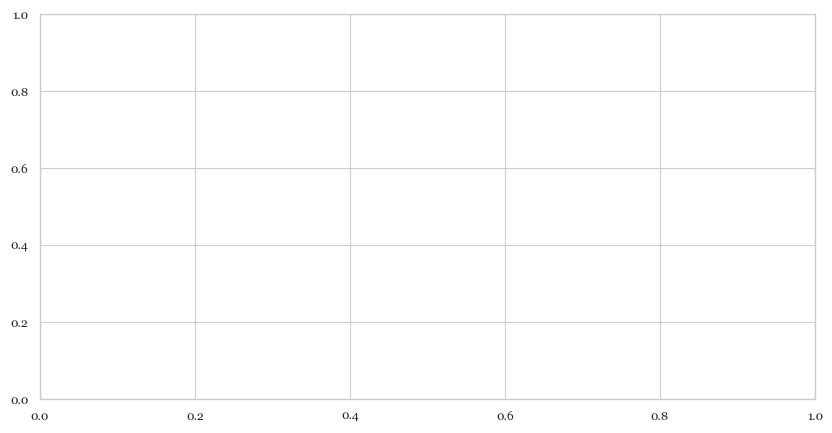

In [10]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
# for split in train_splits[:-1]:
#     ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
print(len(exp.ensembles))
for ens in exp.ensembles:
    print(ens.name)

50
full-ensemble
random_better-accuracy_score-num_gurus-1
random_better-accuracy_score-num_gurus-2
random_better-accuracy_score-num_gurus-3
random_better-accuracy_score-num_gurus-4
random_better-balanced_accuracy_score-num_gurus-1
random_better-balanced_accuracy_score-num_gurus-2
random_better-balanced_accuracy_score-num_gurus-3
random_better-balanced_accuracy_score-num_gurus-4
random_better-f1_score-num_gurus-1
random_better-f1_score-num_gurus-2
random_better-f1_score-num_gurus-3
random_better-f1_score-num_gurus-4
probabilistic_better-accuracy_score-num_gurus-1
probabilistic_better-accuracy_score-num_gurus-2
probabilistic_better-accuracy_score-num_gurus-3
probabilistic_better-accuracy_score-num_gurus-4
probabilistic_better-balanced_accuracy_score-num_gurus-1
probabilistic_better-balanced_accuracy_score-num_gurus-2
probabilistic_better-balanced_accuracy_score-num_gurus-3
probabilistic_better-balanced_accuracy_score-num_gurus-4
probabilistic_better-f1_score-num_gurus-1
probabilistic_bet

In [ ]:
print(exp.ensembles[-5].name)
batch_accs = []
for voter in exp.ensembles[-5].voters:
    batch_accs.append(voter.batch_accuracies)
# exp.ensembles[-5].voters[0].batch_accuracies

max_diversity-f1_score-num_gurus-1


In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["max_diversity-f1_score-num_gurus-1"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

[[0, 50], [53, 53], [60, 63], [70, 70], [80, 80], [82, 82], [94, 94], [96, 96], [99, 99], [178, 178], [195, 201], [267, 267], [269, 269], [293, 299], [333, 333], [361, 388]]


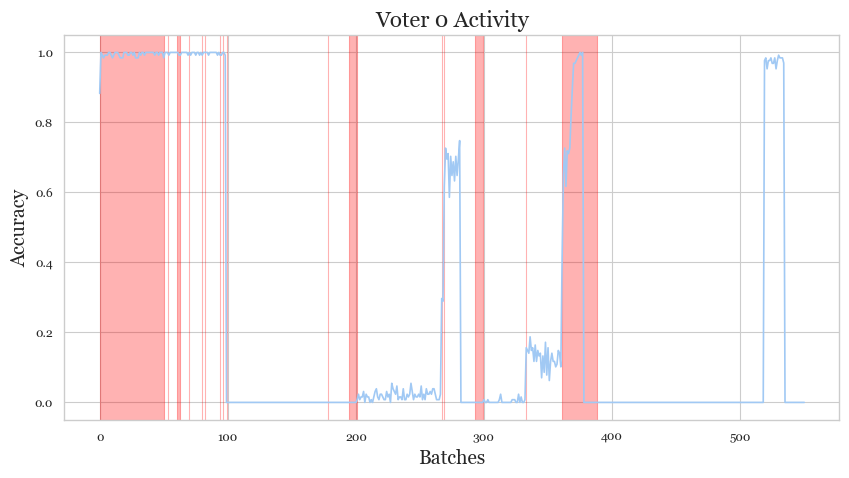

[[0, 50], [57, 57], [94, 94], [108, 108], [122, 122], [178, 178], [195, 201], [258, 258], [297, 297], [300, 302], [376, 376], [389, 470]]


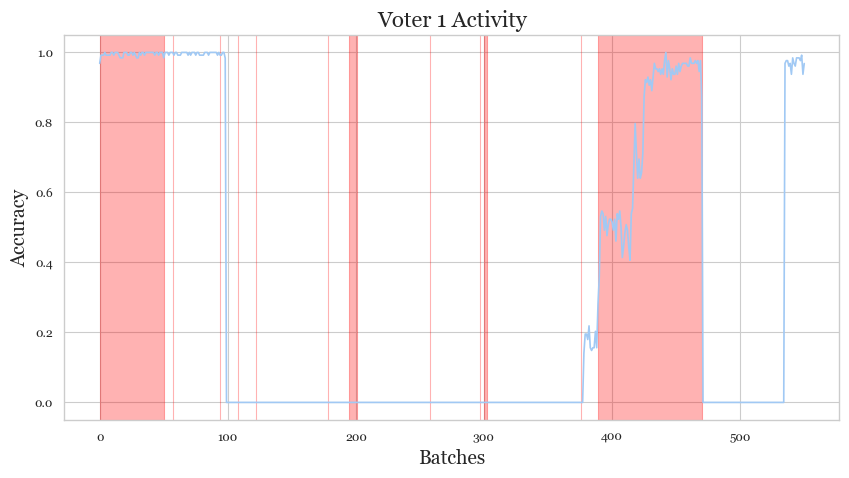

[[0, 50], [80, 81], [85, 85], [87, 87], [93, 177], [179, 194], [297, 297], [300, 302], [376, 376]]


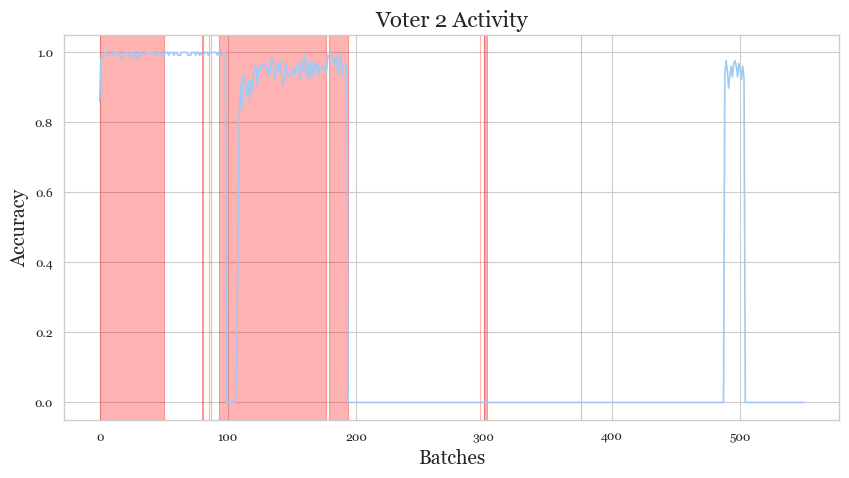

[[0, 50], [52, 52], [82, 82], [122, 122], [124, 124], [178, 178], [195, 258], [376, 376]]


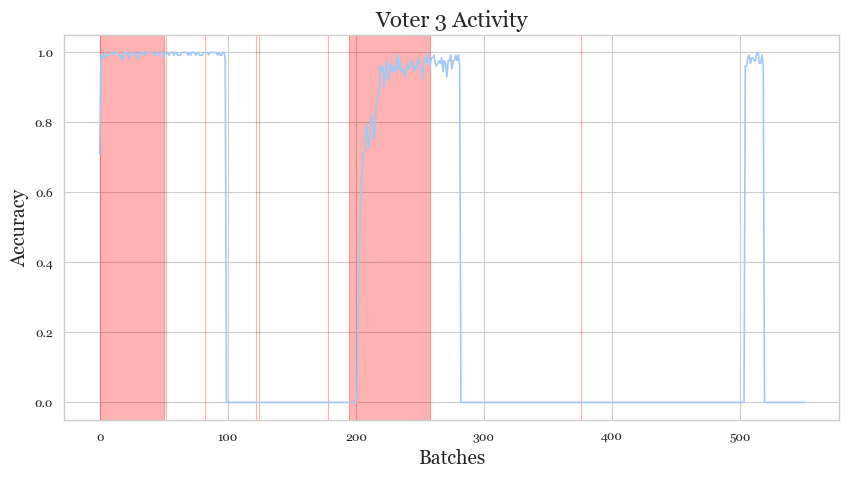

[[0, 59], [62, 62], [64, 79], [82, 84], [86, 92], [115, 115], [121, 121], [123, 123], [178, 178], [195, 201], [253, 253], [255, 255], [259, 292], [376, 376]]


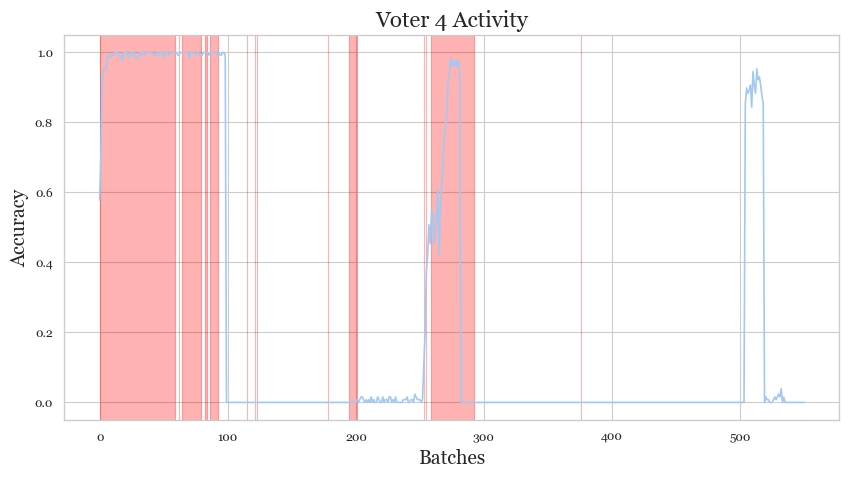

[[0, 50], [80, 80], [94, 94], [131, 131], [178, 178], [195, 201], [266, 266], [376, 376]]


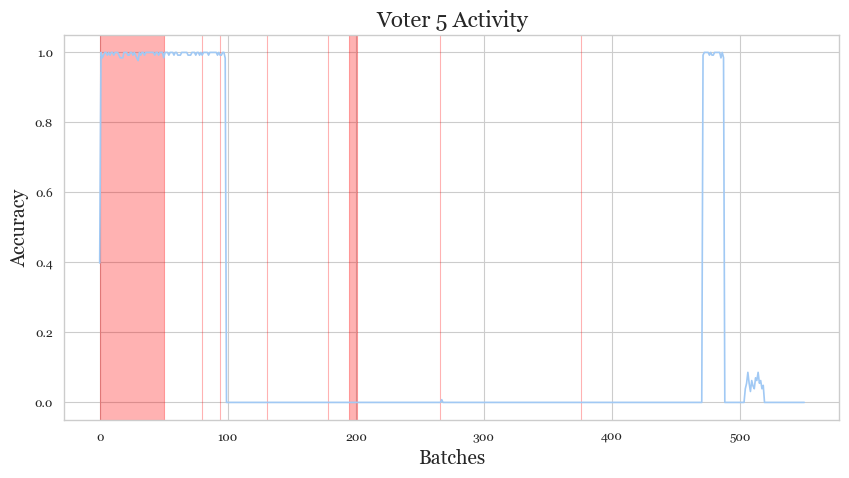

[[0, 50], [52, 52], [60, 60], [80, 80], [98, 98], [110, 110], [122, 122], [178, 178], [195, 201], [259, 259]]


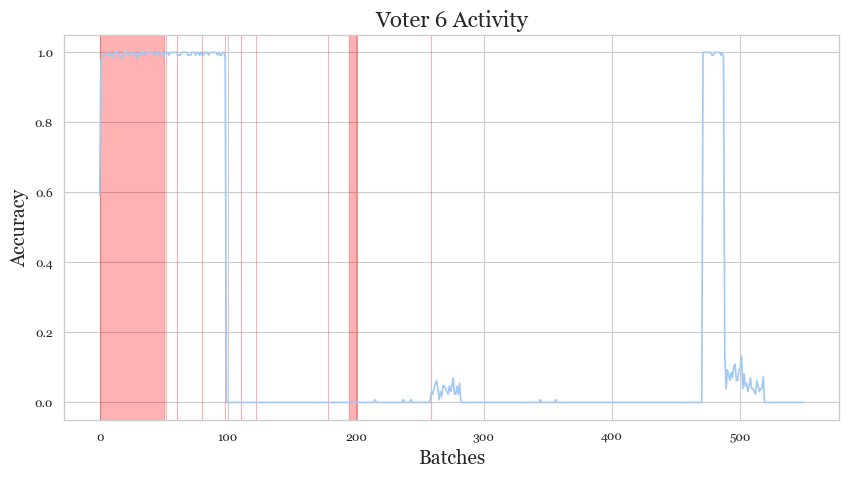

[[0, 50], [52, 52], [69, 69], [81, 81], [132, 132], [178, 178], [195, 201], [266, 266], [294, 294], [297, 297], [300, 360]]


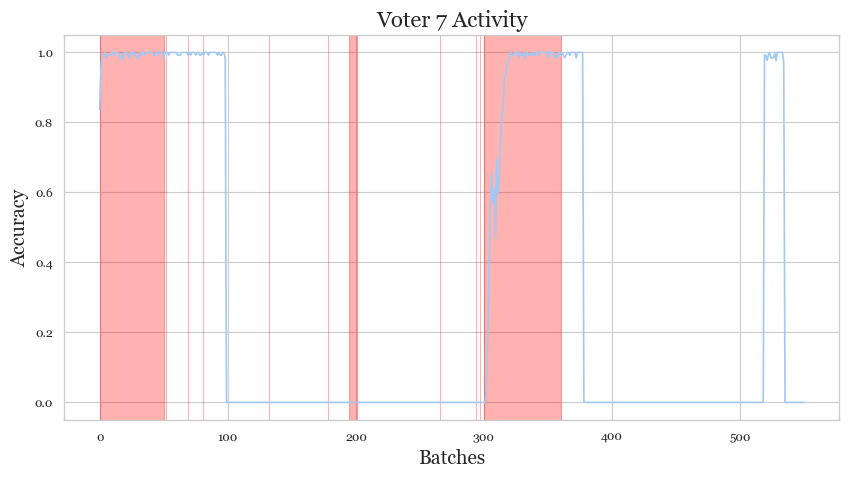

In [ ]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    print(active_streaks)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    # plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    # for split in train_splits[:-1]:
    #     plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter